In [1]:
%autosave 0
!python -V

Autosave disabled
Python 3.7.11


In [2]:
# Uncomment to install required packages
#!conda install -c conda-forge -c pytorch u8darts-all ipywidgets psutil gputil tabulate tensorflow -y

In [3]:
import os
import time
import psutil
import GPUtil
import platform
import tabulate
import datetime

from tabulate import tabulate

print("="*120)
print("-"*48, "Uptime Information", "-"*52)
print(f"Last boot:    ", datetime.datetime.fromtimestamp(psutil.boot_time()))
print(f"Current time: ", datetime.datetime.now())
uptimeSeconds = time.time() - psutil.boot_time()
uptime = time.strftime('%dd %Hh %Mm', time.gmtime(uptimeSeconds))
print(f"Current time: ", uptime)
#print(f"Uptime: ", uptime)
print("-"*48, "System Information", "-"*52)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print("-"*48, "Hardware Information", "-"*50)
print(f"Processor: {uname.processor}")
print("Physical cores:", psutil.cpu_count(logical=False), " - Total cores:", psutil.cpu_count(logical=True))
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.0f}Mhz", f" - Current Frequency: {cpufreq.current:.0f}Mhz")
svmem = psutil.virtual_memory()
print("Total memory (GB):{:.0f}".format(svmem.total/1e9))
print("-"*48, "GPU Information", "-"*55)
gpus = GPUtil.getGPUs()
list_gpus = []
for gpu in gpus:
    gpu_id = gpu.id
    gpu_name = gpu.name
    gpu_load = f"{gpu.load*100}%"
    gpu_free_memory = f"{gpu.memoryFree}MB"
    gpu_used_memory = f"{gpu.memoryUsed}MB"
    gpu_total_memory = f"{gpu.memoryTotal}MB"
    gpu_temperature = f"{gpu.temperature} °C"
    gpu_uuid = gpu.uuid
    list_gpus.append((
        gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
        gpu_total_memory
    ))

print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory",
                                   "temperature", "uuid")))
print("="*120)

------------------------------------------------ Uptime Information ----------------------------------------------------
Last boot:     2022-06-13 19:52:55.022931
Current time:  2022-06-13 19:56:25.022931
Current time:  01d 00h 03m
------------------------------------------------ System Information ----------------------------------------------------
System: Windows
Version: 10.0.19041
Machine: AMD64
------------------------------------------------ Hardware Information --------------------------------------------------
Processor: Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
Physical cores: 10  - Total cores: 20
Max Frequency: 3696Mhz  - Current Frequency: 3696Mhz
Total memory (GB):34
------------------------------------------------ GPU Information -------------------------------------------------------
  id  name                     load    free memory    used memory    total memory
----  -----------------------  ------  -------------  -------------  --------------
   0  NVIDIA 

In [4]:
import time
start = time.time()

#Common module parameters:
NUMPY_RANDOM_SEED=10
figsize = (9, 6)

#Train validate test split (70%/15%/15%). Test split is inferred from test and validate values.
train_size = 0.70
valid_size=0.15


LAZY_WALK_LAG=1 # # of periods (hours) to compute metrics for a lazy walk baseline scenario.

MODEL_NAME_RNN='2v1_ALLDNNs-EPOCHS_1000-48-2-BASE_c1'
MODEL_NAME_LSTM='2v1_ALLDNNs-EPOCHS_100-48-2-BASE_c2'
MODEL_NAME_TCN='2v1_ALLDNNs-EPOCHS_100-48-2-BASE_c3'
MODEL_NAME_GRU='2v1_ALLDNNs-EPOCHS_100-48-2-BASE_c4'
MODEL_NAME_NBEATS='2v1_ALLDNNs-EPOCHS_100-48-2-BASE_c5'
MODEL_NAME_TFT='2v1_ALLDNNs-EPOCHS_100-48-2-BASE_c6'

# FOR MACOS "/darts_logs/" OR "\\darts_logs\\" FOR WIN - CHOOSE ACCORDINGLY:
LOG_PATH="/darts_logs/" 
TENSORBOARD_LOG_PATH_RNN = ((os.getcwd() + LOG_PATH + MODEL_NAME_RNN))
TENSORBOARD_LOG_PATH_LSTM = ((os.getcwd() + LOG_PATH + MODEL_NAME_LSTM))
TENSORBOARD_LOG_PATH_TCN = ((os.getcwd() + LOG_PATH + MODEL_NAME_TCN))
TENSORBOARD_LOG_PATH_GRU = ((os.getcwd() + LOG_PATH + MODEL_NAME_GRU))
TENSORBOARD_LOG_PATH_NBEATS = ((os.getcwd() + LOG_PATH + MODEL_NAME_NBEATS))
TENSORBOARD_LOG_PATH_TFT = ((os.getcwd() + LOG_PATH + MODEL_NAME_TFT))

#Deep Neural Network parameters:
#RANDOM_STATE=31
INPUT_CHUNK_LENGTH = 48 #periods = hours
OUTPUT_CHUNK_LENGTH = 1
FORECAST_HORIZON = 1 #periods = hours
HIST_FOR_TIME_START = '2021-11-10T11:00:00' #must be minimum (FORECAST_HORIZON +1) periods ahead of the test start series

N_EPOCHS_RNN=100
N_EPOCHS_LSTM=100
N_EPOCHS_TCN=100
N_EPOCHS_GRU=100
N_EPOCHS_NBEATS=100
N_EPOCHS_TFT=100

In [5]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel, TCNModel, BlockRNNModel, NBEATSModel, ARIMA, Prophet
from darts.metrics import mape, rmse, r2_score, mae, mse

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [6]:
#DARTS version 0.17.1
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

psutil==5.8.0
GPUtil==1.4.0
platform==1.0.8
numpy==1.21.5
pandas==1.3.4
torch==1.10.2
logging==0.5.1.2


In [7]:
#CONSTANT VALUE TEST TIMESERIES

# np.random.seed(NUMPY_RANDOM_SEED)
# series_constant = tg.constant_timeseries(
#     value=1.0,
#     start=pd.to_datetime(TS_START_DATETIME),
#     end=pd.to_datetime(TS_END_DATETIME),
# #   length=TS_LENGTH,
#     freq=TS_FREQUENCY,
#     column_name='c',
#     )

In [8]:
# #RANDOM WALK TEST TIMESERIES - Creates a random walk univariate TimeSeries, where each step is obtained by sampling a
# #gaussian distribution with mean mean and standard deviation std.

# np.random.seed(NUMPY_RANDOM_SEED)
# series_random_walk = tg.random_walk_timeseries(
#     mean=0.0,
#     std=1.0,
#     start=pd.to_datetime(TS_START_DATETIME),
#     end=pd.to_datetime(TS_END_DATETIME),
# #   length=TS_LENGTH,
#     freq=TS_FREQUENCY,
#     column_name='c',
#     )

In [9]:
df = pd.read_csv(r"C:\Users\User\Downloads\2-price-ohlc-eth-1h-shift_024.csv", parse_dates=["timestamp"])
df['timestamp'] = pd.to_datetime(df.timestamp).dt.tz_localize(None)
nof_missing_values_o = sum(np.isnan(df['o']))
nof_missing_values_h = sum(np.isnan(df['h']))
nof_missing_values_l = sum(np.isnan(df['l']))
nof_missing_values_c = sum(np.isnan(df['c']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['o']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['h']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['l']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['c']))

train_index = int(len(df)*train_size)

df_train = df[0:train_index]
df_rem = df[train_index:]

valid_index = int(len(df)*valid_size)

df_val = df[train_index:train_index+valid_index]
df_test = df[train_index+valid_index:]

series = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['c']).astype(np.float32)
series_covariates = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
train = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['c']).astype(np.float32)
train_covariates = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
val = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['c']).astype(np.float32)
val_covariates = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
test = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['c']).astype(np.float32)
test_covariates = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)

In [10]:
# from darts.utils.statistics import check_seasonality, plot_acf

# print('Seasonality: ',check_seasonality(series, max_lag=(len(series)-1)))
# plot_acf(series, 1, max_lag=(len(series)-1))

In [11]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
test_transformed = transformer.transform(test)
train_covariates_transformed = transformer.fit_transform(train_covariates)
val_covariates_transformed = transformer.transform(val_covariates)
test_covariates_transformed = transformer.transform(test_covariates)

Text(0.5, 1.0, 'Conjunto de Dados Ethereum - Treinamento, Validacao e Teste')

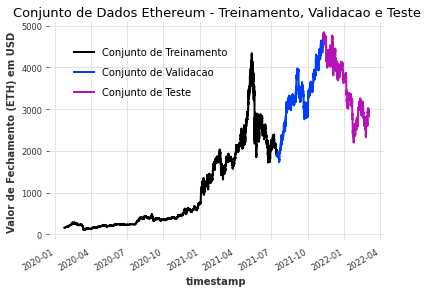

In [12]:
train.plot(label="Conjunto de Treinamento")
val.plot(label="Conjunto de Validacao")
test.plot(label="Conjunto de Teste")
plt.legend(
           borderpad=2,
           labelspacing=1.0,
           title_fontsize='large',
           shadow=False,
           frameon=False,
           loc='best'  
          )
plt.ylabel('Valor de Fechamento (ETH) em USD')
plt.title('Conjunto de Dados Ethereum - Treinamento, Validacao e Teste',fontsize=13)

In [13]:
print("="*72)
print('Dataset type',' -      Start time    -', '     End time','    -Samples', '- %split')
print("-"*72)
print('Full dataset: ', series.start_time(),'', series.end_time(),'', len(series),'     {:.0f}'.format((len(series)/len(series)*100)))
print('Train set:    ', train.start_time(),'', train.end_time(),'', len(train),'      {:.0f}'.format((len(train)/len(series)*100)))
print('Validate set: ', val.start_time(),'', val.end_time(),' ', len(val),'      {:.0f}'.format((len(val)/len(series)*100)))
print('Test set:     ', test.start_time(),'', test.end_time(),' ', len(test),'      {:.0f}'.format((len(test)/len(series)*100)))
print("="*72)

Dataset type  -      Start time    -      End time     -Samples - %split
------------------------------------------------------------------------
Full dataset:  2020-01-25 00:00:00  2022-03-03 18:00:00  18451      100
Train set:     2020-01-25 00:00:00  2021-07-16 02:00:00  12915       70
Validate set:  2021-07-16 03:00:00  2021-11-08 09:00:00   2767       15
Test set:      2021-11-08 10:00:00  2022-03-03 18:00:00   2769       15


In [14]:
tic_prep = time.time()
prep_elapsed_time = tic_prep - start
print(prep_elapsed_time,'seconds')

8.76194453239441 seconds


In [15]:
for i in range (32):
    tic_ann_begin = time.time()

    
    gru_model = BlockRNNModel(
    model="GRU",
    hidden_size=24,
    n_rnn_layers=1,
    dropout=0.1,
    batch_size=16,
    n_epochs=N_EPOCHS_GRU,
    optimizer_kwargs={"lr": 1e-3},
    model_name=MODEL_NAME_GRU,
    log_tensorboard=True,
    random_state=i,
    output_chunk_length=FORECAST_HORIZON,        
    input_chunk_length=INPUT_CHUNK_LENGTH,
    loss_fn=torch.nn.MSELoss(),
    optimizer_cls=torch.optim.Adam,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={
          'accelerator': 'gpu', 'gpus': [0],
          'progress_bar_refresh_rate': False,
          'enable_model_summary': False,
       },
    )

    gru_model.fit(
        series=train_transformed,
        val_series=val_transformed,
        verbose=False,
    )

    best_gru_model = BlockRNNModel.load_from_checkpoint(model_name=MODEL_NAME_GRU, best=True)
    
    tic_ann_end = time.time()
    ann_elapsed_time = tic_ann_end - tic_ann_begin

    
    backtest_series_gru = best_gru_model.historical_forecasts(
    series=test_transformed,
    start=pd.Timestamp(HIST_FOR_TIME_START),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=False,
    )


    tic_ann_backtest_end = time.time()
    ann_backtest_elapsed_time= tic_ann_backtest_end - tic_ann_end


    print(
      "{:.0f};".format(i),
      "{:.8f}".format(mse(backtest_series_gru, test_transformed)),
      "{:.8f};".format(mae(backtest_series_gru, test_transformed)),
      "{:.8f};".format(rmse(backtest_series_gru, test_transformed)),
      "{:.8f};".format(r2_score(backtest_series_gru, test_transformed)),
      "{:.8f};".format(mape(backtest_series_gru, test_transformed)),
      "{:.8f}".format(ann_elapsed_time),
      "{:.8f}".format(ann_backtest_elapsed_time)
    )
    
    arquivo = open('8v1_ETH-EPOCHS_100-48-1-16-GRU_shift024.txt', 'a')
    print("{:.0f};".format(i),
    "{:.8f};".format(mse(backtest_series_gru, test_transformed)),
    "{:.8f};".format(mae(backtest_series_gru, test_transformed)),
    "{:.8f};".format(rmse(backtest_series_gru, test_transformed)),
    "{:.8f};".format(r2_score(backtest_series_gru, test_transformed)),
    "{:.8f};".format(mape(backtest_series_gru, test_transformed)),
    "{:.8f}".format(ann_elapsed_time),
    "{:.8f}".format(ann_backtest_elapsed_time), file=arquivo) 
    arquivo.close()

0; 0.00005084 0.00497411; 0.00712998; 0.99805682; 0.63182004; 526.16074944 126.48608255
1; 0.00005285 0.00512810; 0.00727002; 0.99795953; 0.65192841; 512.32069325 96.37345386
2; 0.00005265 0.00510729; 0.00725626; 0.99799327; 0.64922501; 516.60392666 96.35410666
3; 0.00005052 0.00494939; 0.00710805; 0.99806908; 0.62983013; 517.83087420 97.16443110
4; 0.00005352 0.00511456; 0.00731602; 0.99797485; 0.64822100; 519.16508532 97.12486339
5; 0.00005202 0.00502887; 0.00721236; 0.99800250; 0.63689086; 519.00497246 97.11726117
6; 0.00005001 0.00491596; 0.00707178; 0.99811754; 0.62798369; 518.62760925 96.81982255
7; 0.00005261 0.00507900; 0.00725350; 0.99797675; 0.64149210; 520.14247894 97.77499437
8; 0.00005239 0.00507148; 0.00723840; 0.99800395; 0.64393603; 518.85045886 97.20525742
9; 0.00005342 0.00515468; 0.00730898; 0.99794183; 0.65688821; 518.18745708 98.15365672
10; 0.00005522 0.00525992; 0.00743100; 0.99786034; 0.66298456; 517.87928700 96.27719355
11; 0.00005425 0.00519559; 0.00736531; 0.